In [1]:
# Derived from the Copyright 2019 The TensorFlow Authors.
# Changes implied by LUT course ADALM group A9, Aleksis Tammi

#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Time series forecasting

The original code, of which this is a heavily modified derivate of:

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/time_series"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/time_series.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2025-11-23 21:53:48.480478: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-23 21:53:49.803434: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-23 21:53:54.402782: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## The ADM dataset modelled by LSTM and coparative models

In [3]:
csv_path = "./data/AMD_merged.csv"

The aim is to predict next days closing price from previous days data. Start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [4]:
df = pd.read_csv(csv_path)

print(df.iloc[0])

df["Date"] = pd.to_datetime(df["Date"])

df = df.set_index("Date")
# Slice [start:stop:step], starting from index 5 take every 6th record.
#df = df[5::6]

#date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Date                     2020-01-02
Open                      46.860001
High                          49.25
Low                       46.630001
Close                     49.099998
Volume                   80331100.0
SMA_20                      43.0105
SMA_50                      39.2072
EMA_20                     43.67221
EMA_50                    39.912493
WMA_20                    44.549191
ADX_14                    39.171538
RSI_14                    78.316758
ROC_10                    14.800089
MACD                        2.38986
MACD_signal                2.059646
MACD_hist                  0.330214
BBL                       37.095189
BBM                         43.0105
BBU                       48.925811
ATR_14                     1.419371
OBV                    1818999400.0
MFI_14                     84.67671
CMF_20                     0.172622
 Gold_Open                   1524.5
 Gold_High              1528.699951
 Gold_Low                    1518.0
 Gold_Close             1518

### Perform log-returns transform

The log-returns makes the data stationary, so the model sees better structured data.

In [5]:
df_stationary = df.copy()



# Check all values > 0 for log and division
# shift each column only if needed
for col in df.columns:
    min_val = df[col].min()
    
    if col in ["Volume", "NASDAQ_Volume", "Oil_Volume"]:
        # normalize these columns wihtout log returns sinve they are not
        # price type of data
        df_stationary[col] = df_stationary[col] / df_stationary[col].max()
        continue

    if min_val <= 0.001:
        if min_val >= -0.001:
            # if the negative values are very small, just clip them to close zero
            # this allows the division and log to work
            df_stationary[col] = df_stationary[col].clip(lower=0.001)
        else:
            # otherwice move the values to positive range
            df_stationary[col] = df_stationary[col] - min_val + 0.001
            print(col, " moved to positive range.")

    # Compute log returns
    df_stationary[col] = np.log(df_stationary[col] / df_stationary[col].shift(1))





# Drop the NaN from the first row
df_stationary = df_stationary.dropna()

ROC_10  moved to positive range.
MACD  moved to positive range.
MACD_signal  moved to positive range.
MACD_hist  moved to positive range.
CMF_20  moved to positive range.
 Oil_Open  moved to positive range.
 Oil_Low  moved to positive range.
 Oil_Close  moved to positive range.


### Split the data

We use a 70%, 20%, 10% split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting.

In [6]:
column_indices = {name: i for i, name in enumerate(df_stationary.columns)}

n = len(df_stationary)
train_df = df_stationary[0:int(n*0.7)]
val_df = df_stationary[int(n*0.7):int(n*0.9)]
test_df = df_stationary[int(n*0.9):]

num_features = df_stationary.shape[1]

## Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

- The width (number of time steps) of the input and label windows.
- The time offset between them.
- Which features are used as inputs, labels, or both.

This tutorial builds a variety of models (including Linear, DNN, CNN and RNN models), and uses them for both:

- *Single-output*, and *multi-output* predictions.
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.


Our model that makes a prediction one day into the future, given six days of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [7]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

In our case we define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [8]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['Close']`. Initially, this tutorial will build models that predict single output labels.

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [9]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [log returns]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [d]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

You can plot the other columns, but the example window `w2` configuration only has labels for the `Close` column.

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [10]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method defined earlier. Also, add a standard example batch for easy access and plotting:

In [11]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [12]:
wide_window = WindowGenerator(
    input_width=30, label_width=1, shift=1,
    label_columns=['Close'])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['Close']

Iterating over a `Dataset` yields concrete batches:

In [13]:
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

2025-11-23 21:53:55.696927: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Inputs shape (batch, time, features): (32, 30, 58)
Labels shape (batch, time, features): (32, 1, 1)


2025-11-23 21:53:56.053084: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


This expanded window can be passed directly to the same `baseline` model without any code changes. This is possible because the inputs and labels have the same number of time steps, and the baseline just forwards the input to the output:

![One prediction 1h into the future, ever hour.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/last_window.png?raw=1)

This tutorial trains many models, so package the training procedure into a function:

In [14]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

def compile_and_fit2(model, window, epochs=20):
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    history = model.fit(window.train, epochs=epochs, verbose=0) # verbose=0 to reduce noise
    return history

Train the model and evaluate its performance:

### Recurrent neural network LSTM

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

You can learn more in the [Text generation with an RNN](https://www.tensorflow.org/text/tutorials/text_generation) tutorial and the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide.

We use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction:

![An LSTM warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers.
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [15]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

lstm_model_complex = tf.keras.models.Sequential([
    # Apply BN to the input of the LSTM layer
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.LayerNormalization(axis=-1),
    
    # Shape [batch, time, features] => [batch, time, lstm_units1]
    tf.keras.layers.LSTM(128, return_sequences=True), 
    #tf.keras.layers.Dropout(0.3),  # Add regularization

    # Shape [batch, time, lstm_units1] => [batch, time, lstm_units2]
    tf.keras.layers.LSTM(64, return_sequences=True), # False because it's the last LSTM layer
    #tf.keras.layers.Dropout(0.3), 

    # Shape => [batch, features]
    tf.keras.layers.Dense(units=1)
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [16]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 30, 58)
Output shape: (32, 30, 1)


In [17]:
history = compile_and_fit(lstm_model, wide_window)
complex_history = compile_and_fit(lstm_model_complex, wide_window)

IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

val_performance['LSTM complex'] = lstm_model_complex.evaluate(wide_window.val, return_dict=True)
performance['LSTM complex'] = lstm_model_complex.evaluate(wide_window.test, verbose=0, return_dict=True)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0050 - mean_absolute_error: 0.0488 - val_loss: 0.0015 - val_mean_absolute_error: 0.0297
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - mean_absolute_error: 0.0304 - val_loss: 0.0012 - val_mean_absolute_error: 0.0258
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014 - mean_absolute_error: 0.0279 - val_loss: 0.0011 - val_mean_absolute_error: 0.0241
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - mean_absolute_error: 0.0276 - val_loss: 9.8391e-04 - val_mean_absolute_error: 0.0233
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - mean_absolute_error: 0.0276 - val_loss: 9.5827e-04 - val_mean_absolute_error: 0.0231
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0013 - mean_absolute_error: 0.0272 - val_loss: 9.2899e-04 - val_mean_absolute_error: 0.0226
Epoch 7/50
 1/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0013 - mean_absolute_error: 0.027

KeyboardInterrupt: 

In [29]:
def compile_and_fit_no_validation(model, window, epochs=25):
  # compile (same as original compile_and_fit)
  model.compile(
      loss=tf.keras.losses.MeanSquaredError(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.MeanAbsoluteError()])
  # fit without validation_data and without EarlyStopping
  history = model.fit(window.train, epochs=epochs, verbose=2)
  return history


In [ ]:

# Example: define your 4 folds as (train_start, train_end, test_start, test_end)
# Replace the example date ranges below with your exact splits.
folds = [
  ("2020-01-02", "2020-12-31", "2021-01-04", "2021-03-31"),
  ("2020-01-02", "2021-12-31", "2022-01-03", "2022-12-30"),
  ("2020-01-02", "2022-12-30", "2023-01-03", "2023-12-29"),
  ("2020-01-02", "2023-12-29", "2024-01-02", "2024-12-26"),
]

results = {}
for i, (ts, te, ss, se) in enumerate(folds, start=1):
  train_fold = df_stationary.loc[ts:te].copy()
  test_fold  = df_stationary.loc[ss:se].copy()

  # If you truly want no validation set, either pass val_df=None or reuse train as placeholder.
  # Here we reuse train as val_df placeholder to keep WindowGenerator.val available if referenced elsewhere.
  wg = WindowGenerator(
      input_width=30, label_width=1, shift=1,
      train_df=train_fold, val_df=train_fold, test_df=test_fold,
      label_columns=['Close'])

  # Make a fresh model instance (re-initialize weights) for each fold if needed:
  model = tf.keras.models.clone_model(lstm_model)  # clones architecture only
  model_complex = tf.keras.models.clone_model(lstm_model_complex)  # clones architecture only

  # Train fixed number of epochs
  history = compile_and_fit_no_validation(model, wg, epochs=5)
  IPython.display.clear_output()
  history_complex = compile_and_fit_no_validation(model_complex, wg, epochs=5)
  IPython.display.clear_output()


  # Evaluate on test set
  results[f"LSTM fold {i}"] = model.evaluate(wg.test, return_dict=True)
  results[f"LSTM complex fold {i}"] = model_complex.evaluate(wg.test, verbose=0, return_dict=True)


### Performance

With this dataset typically each of the models does slightly better than the one before it:

In [27]:
cm = lstm_model.metrics[1]
cm.metrics

[<MeanAbsoluteError name=mean_absolute_error>]

In [28]:
val_performance

NameError: name 'val_performance' is not defined

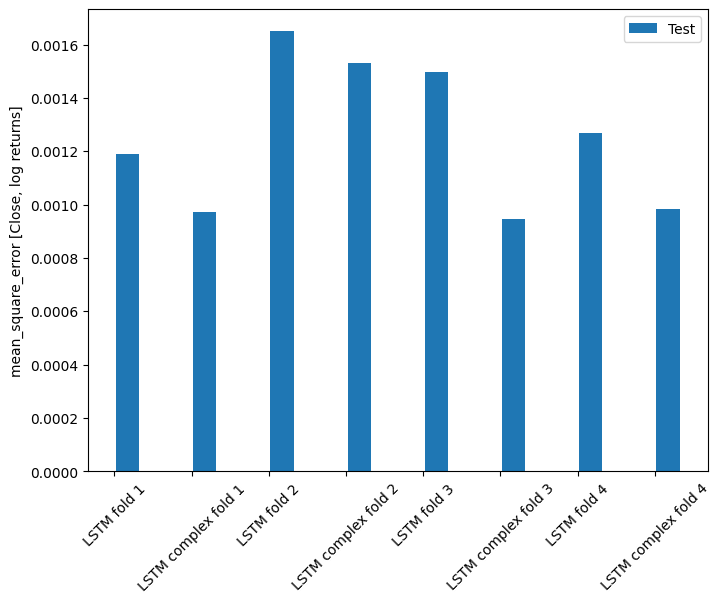

In [30]:
x = np.arange(len(results))
width = 0.3
metric_name = 'loss'
test_mse = [v[metric_name] for v in results.values()]

plt.ylabel('mean_square_error [Close, log returns]')
plt.xticks(ticks=x, labels=results.keys(),
           rotation=45)
plt.bar(x + 0.17, test_mse, width, label='Test')
_ = plt.legend()

In [31]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'loss'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [Close, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

NameError: name 'performance' is not defined

In [32]:
# Wrap the sequence model so it returns only the last time-step (shape [batch, 1, features])
lstm_model_single_step = tf.keras.Sequential([
    lstm_model,
    tf.keras.layers.Lambda(lambda x: x[:, -1, :])   # keep last timestep and preserve time dim
])
lstm_model_complex_single_step = tf.keras.Sequential([
    lstm_model_complex,
    tf.keras.layers.Lambda(lambda x: x[:, -1, :])   # keep last timestep and preserve time dim
])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - mean_absolute_error: 0.0248      


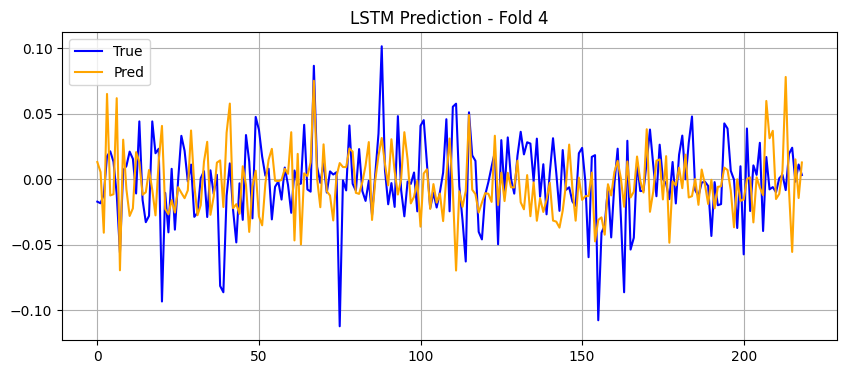

Fold 4 Plot Generated. True shape: (219, 1, 1), Pred shape: (219, 1)


In [33]:
import os

folds = [
  ("2020-01-02", "2020-12-31", "2021-01-04", "2021-03-31"),
  ("2020-01-02", "2021-12-31", "2022-01-03", "2022-12-30"),
  ("2020-01-02", "2022-12-30", "2023-01-03", "2023-12-29"),
  ("2020-01-02", "2023-12-29", "2024-01-02", "2024-12-26"),
]

for i, (ts, te, ss, se) in enumerate(folds, start=1):
    print(f"\nProcessing Fold {i}...")

    # A. Prepare Data
    train_fold = df_stationary.loc[ts:te].copy()
    test_fold  = df_stationary.loc[ss:se].copy()

    wg = WindowGenerator(
        input_width=30, label_width=1, shift=1,
        train_df=train_fold, val_df=train_fold, test_df=test_fold,
        label_columns=['Close'])

    # Train fixed number of epochs
    history = compile_and_fit_no_validation(model, wg, epochs=15)
    IPython.display.clear_output()
    history_complex = compile_and_fit_no_validation(model_complex, wg, epochs=15)
    IPython.display.clear_output()


    # Evaluate on test set
    results[f"LSTM fold {i}"] = model.evaluate(wg.test, return_dict=True)
    results[f"LSTM complex fold {i}"] = model_complex.evaluate(wg.test, verbose=0, return_dict=True)


    # C. THE FIX: Extract Data Safely using .unbatch()
    # This converts the TF Dataset back into raw Numpy arrays.
    # It ensures 'x' and 'y' are perfectly aligned 1-to-1.
    x_test_list = []
    y_true_list = []
    
    # iterate through every single sample, not batches
    for x, y in wg.test.unbatch(): 
        x_test_list.append(x.numpy())
        y_true_list.append(y.numpy())

    x_test = np.array(x_test_list)
    y_true = np.array(y_true_list)

    # predict on the numpy array
    y_pred = lstm_model_complex_single_step.predict(x_test, verbose=0)

    # Plot
    plt.figure(figsize=(10,4))
    
    # .flatten() ensures we are plotting 1D lines
    plt.plot(y_true.flatten(), label="True", color="blue")
    plt.plot(y_pred.flatten(), label="Pred", color="orange")
    
    plt.title(f"LSTM Prediction - Fold {i}")
    plt.legend()
    plt.grid(True)
    
    # Save and Show
    plt.savefig(f"fig/lstm_fold_{i}.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    print(f"Fold {i} Plot Generated. True shape: {y_true.shape}, Pred shape: {y_pred.shape}")

In [34]:
results

{'LSTM fold 1': {'loss': 0.0009629633859731257,
  'mean_absolute_error': 0.02496011182665825},
 'LSTM complex fold 1': {'loss': 0.0010797486174851656,
  'mean_absolute_error': 0.026328956708312035},
 'LSTM fold 2': {'loss': 0.0015594104770570993,
  'mean_absolute_error': 0.030965788289904594},
 'LSTM complex fold 2': {'loss': 0.001456054742448032,
  'mean_absolute_error': 0.029861217364668846},
 'LSTM fold 3': {'loss': 0.0012812354834750295,
  'mean_absolute_error': 0.0254195686429739},
 'LSTM complex fold 3': {'loss': 0.000926490465644747,
  'mean_absolute_error': 0.02243139035999775},
 'LSTM fold 4': {'loss': 0.0011603866005316377,
  'mean_absolute_error': 0.024829788133502007},
 'LSTM complex fold 4': {'loss': 0.0009451053920201957,
  'mean_absolute_error': 0.02238362841308117}}